# Capstone Project
## The Battle of the Neighborhoods
### Week 2
## Notebook - Code
---

### Import libraries and packages necessary

In [1]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import requests
import lxml.html as lh
from IPython.display import display
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import json # library to handle JSON files
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means and DBSCAN for clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import random
!pip install alphashape
import alphashape
!pip install descartes
from descartes import PolygonPatch
from area import area

#from scipy.spatial import ConvexHull, convex_hull_plot_2d

print('Libraries imported')

Libraries imported


### Load my Foursquare data (hidden cell)

In [2]:
# @hidden_cell

CLIENT_ID = '4T1QFWXUIY5OETEK2M5ND1UBTC41JTJN5SUBMRUVK15DO3KI' # my Foursquare ID
CLIENT_SECRET = 'G5SB5GSZRPFDGZCBYAVKCVQKW2SE5IASRCKPCGZM3TICYQAK' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Function for extracting venues from Foursquare using:
 * Coordenates (latitude and longitude)
 * Radius in meters
 * Number Limiting how many venues are returned 

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=500):
    
    venues_list=[]
    total = len(names)
    for name, lat, lng in zip(names, latitudes, longitudes):
        total-= 1
        print([], end ='\r')
        print(total, end ='')
        #if len(venues_list) < 1:
        #    print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('')
    print('DONE!')
    return(nearby_venues)

### Code for extracting from Wikipedia the Toronto boroughs, neighbourhoods and postal codes 

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Create a handle to the contents of the website
page = requests.get(url)

# Store the contents of the website under doc
doc = lh.fromstring(page.content)

# Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
row_length = [len(T) for T in tr_elements[:10]]

# Create an empty list
column=[]
i=0
# For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print('%d: "%s"'%(i,name))
    column.append((name,[]))

1: "Postal Code
"
2: "Borough
"
3: "Neighbourhood
"


### Process the Wikipedia data from Toronto

In [5]:
for j in range(1,len(tr_elements)):
    # T is our j'th row
    T=tr_elements[j]
    
    # If row is not of size 3, the //tr data is not from our table 
    if len(T)!=row_length[0]:
        break
    
    # i is the index of our column
    i=0
    
    # Iterate through each element of the row
    for t in T.iterchildren():
        data = t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        # Append the data to the empty list of the i'th column
        column[i][1].append(data)
        # Increment i for the next column
        i+=1

### Create a Pandas dataframe with the Wikipedia data from Toronto

In [6]:
Dict = {title:column for (title,column) in column}
df = pd.DataFrame(Dict)
display(df.head())
print(df.shape)

,Postal Code,Borough,Neighbourhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


(181, 3)


### Clean the dataframe

In [7]:
# Clean the data
# Get rid of the \n symbols 
df = df.replace('\n','', regex=True)
df.columns = df.columns.str.replace('\n','', regex=True)

# Drop rows with District == 'Not assigned'
df.drop(df[df.iloc[:,1] == 'Not assigned'].index, inplace=True)
nan_value = np.nan
df.replace('', nan_value, inplace=True)
df = df.dropna(how='any')

# Replace cell in Neighborhood == 'Not assigned' with Borough values from the same row
df = df.rename(columns={'Neighbourhood': 'Neighborhood'})
condition = df.Neighborhood == 'Not assigned'

df.Neighborhood[condition] = df.iloc[:,1]    
display(df.head())

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
print('The number of rows in the dataframe is: {}'.format(df.shape[0]))

The number of rows in the dataframe is: 103


### Load my Foursquare data

In [9]:
# @hidden_cell

CLIENT_ID = '4T1QFWXUIY5OETEK2M5ND1UBTC41JTJN5SUBMRUVK15DO3KI' # my Foursquare ID
CLIENT_SECRET = 'G5SB5GSZRPFDGZCBYAVKCVQKW2SE5IASRCKPCGZM3TICYQAK' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Function for extracting venues from Foursquare using:
 * Coordenates (latitude and longitude)
 * Radius in meters
 * Number limiting how many venues are returned 

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=500):
    
    venues_list=[]
    total = len(names)
    for name, lat, lng in zip(names, latitudes, longitudes):
        total-= 1
        print([], end ='\r')
        print(total, end ='')
        #if len(venues_list) < 1:
        #    print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('')
    print('DONE!')
    return(nearby_venues)

### Download Geospatial data and link Toronto's postal codes to coordinates (latitude and longitude) 

In [11]:
url = 'https://cocl.us/Geospatial_data'
df_geo = pd.read_csv(url)
df = df.merge(df_geo, how = 'inner', on = 'Postal Code' )

### Getting venues from Toronto using de function coded before  

In [13]:
# Getting venues from all Toronto's 
print('Getting venues, please be patient')
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
toronto_venues.shape

Getting venues, please be patient
0
DONE!


(2146, 7)

### Define the keywords contained in the categories and filter data in a new filtered dataframe

In [14]:
# Define the keywords contained in the categories to filter and to keep in a new filteres dataframe
bars_list = ['Bar', 'Pub']
food_list = ['Restaurant', 'Pizza', 'Burrito', 'Food', 'BBQ', 'Chicken', 'Bistro', 'Diner', 'Burger', 'Taco', 'Soup', 'Wings', 'Steakhouse']
music_list = ['Music', 'Nightclub']
lists = [bars_list, food_list, music_list]
category_list = ['Drinks','Food', 'Music'] 

df_filtered = pd.DataFrame(columns = toronto_venues.columns)
for list_venues,category in zip(lists,category_list): 
    for venue in list_venues:
        tmp = toronto_venues[toronto_venues['Venue Category'].str.contains(venue)]  
        tmp.insert(1,'Drinks_Food_Music',category)
        df_filtered = pd.concat([df_filtered, tmp], ignore_index=True, sort=False)
 
# Drop 'Barber' category that is also selected using 'Bar' as keyword but is not intended
df_filtered.drop(df_filtered[df_filtered['Venue Category'].str.contains('Barber')].index, inplace = True)
df_filtered.Drinks_Food_Music = pd.Categorical(df_filtered.Drinks_Food_Music)
df_filtered['Drinks_Food_Music_Code'] = df_filtered.Drinks_Food_Music.cat.codes
print(df_filtered.shape)
df_filtered.head()

(799, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Drinks_Food_Music,Drinks_Food_Music_Code
0,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Bar Volo,43.665462,-79.385692,Beer Bar,Drinks,0
1,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,SUDS,43.659880,-79.394712,Bar,Drinks,0
2,"Garden District, Ryerson",43.657162,-79.378937,Duke's Refresher + Bar,43.658980,-79.382949,Bar,Drinks,0
3,"Garden District, Ryerson",43.657162,-79.378937,Reds Midtown Tavern,43.659128,-79.382266,Wine Bar,Drinks,0
4,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,Drinks,0


### Function to draws a Folium map, coloring the venue with a category colorcode 

In [17]:
# This function draws a map and colors the venue with a category colorcode 
def draw_map(latitude, longitude, df, cluster, clusters):
    
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around primary location
    # add venues to the map as colored circle markers
    if cluster == 'none':
        labels = df.Drinks_Food_Music
        code = df.Drinks_Food_Music_Code
    elif cluster == 'kmeans':
        labels = df.kmeans_label
        code = df.kmeans_label
    elif cluster == 'DBSCAN':
        labels = df.DBSCAN_label
        code = df.DBSCAN_label
            
    nb_codes = max(code)+1
    if nb_codes > 11:
        x = np.arange(nb_codes)
        ys = [i + x + (i*x)**2 for i in range(nb_codes)]
        colors_array = cm.jet(np.linspace(0, 1, len(ys)))
        color_map = [colors.rgb2hex(i) for i in colors_array]
        color_map = random.sample(color_map, len(color_map))
    else:
        color_map =  ('red','blue', 'lightgreen', 'purple', 'orange', 'darkred', 'darkgreen', 'cadetblue','darkpurple', 'darkblue', 'pink', 'beige')
        
    for lat, lng, label, i in zip(df['Venue Latitude'], df['Venue Longitude'], labels , df.index.tolist()):
        if label == -1:
            # Black used for noise.
            col = 'grey'
        else:
            col = color_map[code[i]]
    
        folium.features.CircleMarker(
            [lat, lng],
            radius=7,
            color='#000000',
            weight=1,
            popup=str(label),
            fill=True,
            fill_color=col,
            fill_opacity=0.7
            ).add_to(venues_map)
    
    ### 
    if cluster == 'DBSCAN': 
        for lat, lng, label, area, venue_count, i in zip(clusters['mean_latitude'], clusters['mean_longitude'], 
                                                         clusters['DBSCAN_label'], clusters['Area_m2'], clusters['venue_count'], df.index.tolist()):
            folium.Marker(
                    location=[lat, lng],
                    popup='Cluster #'+str(label),
                    icon=folium.Icon(color='black',icon_color=color_map[label])
                    ).add_to(venues_map)
                    
    # display map
    return(venues_map)

### Map all venues and colorcode with Drinks, Food and Music categories

In [18]:
latitude = df_filtered['Venue Latitude'].mean()
longitude = df_filtered['Venue Longitude'].mean()
draw_map(latitude,longitude,df_filtered,'none', [])

## Cluster the Food, Bars and Music venues

### K-means clustering

In [19]:
# First transform data to standardize features by removing the mean and scaling to unit variance
X = df_filtered[['Venue Latitude', 'Venue Longitude']].values
X = StandardScaler().fit_transform(X)

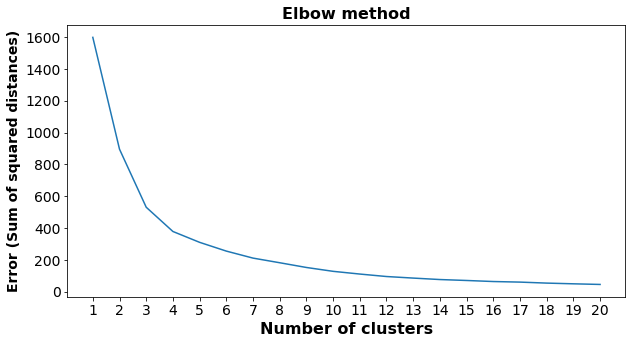

In [20]:
error =[]
max_clusters = 21
for num_clusters in range(1, max_clusters):
    k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=30)
    k_means.fit(X)
    error.append(k_means.inertia_)

x = range(1, max_clusters)
# initialize the plot with the specified dimensions
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, error)
ax.set_title('Elbow method', fontweight='bold', fontsize=16)
ax.set_xticks(x)
ax.tick_params(labelsize=14)
ax.set_xlabel('Number of clusters', fontweight='bold', fontsize=16)
ax.set_ylabel('Error (Sum of squared distances)', fontweight='bold', fontsize=14)
plt.show()

In [21]:
# Selecting k = 9 for clustering the selected venues
k_means = KMeans(init="k-means++", n_clusters=9, n_init=100)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
df_filtered.drop(df_filtered[df_filtered['Venue Category'].str.contains('Barber')].index, inplace = True)
df_filtered['kmeans_label'] = k_means_labels

### Map all venues and colorcode with K-means labels

In [22]:
latitude = df_filtered['Venue Latitude'].mean()
longitude = df_filtered['Venue Longitude'].mean()
draw_map(latitude,longitude,df_filtered, 'kmeans', [])

### DBSCAN clustering

In [23]:
# Compute DBSCAN
# using a maximum distance of 0.06 within the cluster and a minimum number of elements od 10 per cluter
db = DBSCAN(eps=0.06, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

df_filtered['DBSCAN_label'] = labels

Estimated number of clusters: 14
Estimated number of noise points: 264
Silhouette Coefficient: 0.178


### Finding the alpha shape and the area of each DBSCAN cluster

In [60]:
label_list = df_filtered.DBSCAN_label.unique()
cols = ['DBSCAN_label', 'venue_count', 'mean_latitude', 'mean_longitude', 'Coordinates', 'Polygon','Area_m2']
clusters = pd.DataFrame(columns = cols)
num = []
count = []
lat = []
lng = []
mean_lat = []
mean_lng = []
coords = []
alpha_shapes = []
areas = []

for i in label_list:
    if i >= 0:
        count.append(df_filtered[df_filtered.DBSCAN_label == i].count()[1])
        tmp_lat = df_filtered[df_filtered.DBSCAN_label == i]['Venue Latitude']
        tmp_lng = df_filtered[df_filtered.DBSCAN_label == i]['Venue Longitude']
        tmp_lat = tmp_lat[:,np.newaxis]
        tmp_lng = tmp_lng[:,np.newaxis]
        coord = np.concatenate((tmp_lat,tmp_lng),axis=1)
        alpha_shape = alphashape.alphashape(coord, 450.0) # <--- Parameter of the alpha shape algorithm, the smaller it is the more concave the polygon 
        num.append(i)
        lat.append(tmp_lat)
        lng.append(tmp_lng)
        mean_lat.append(np.mean(tmp_lat))
        mean_lng.append(np.mean(tmp_lng))
        coords.append(coord)
        alpha_shapes.append(alpha_shape)
        obj = {'type':'Polygon','coordinates':[coord.tolist()]}
        tmp_area = area(obj)
        areas.append(tmp_area)

clusters.venue_count = count
clusters.DBSCAN_label = num
clusters.Coordinates = coords
clusters.mean_latitude = mean_lat
clusters.mean_longitude = mean_lng
clusters.Polygon = alpha_shape
clusters.Area_m2 = areas
clusters.head()

clusters.sort_values(by=['Area_m2']).head()

,DBSCAN_label,venue_count,mean_latitude,mean_longitude,Coordinates,Polygon,Area_m2
7,7,12,43.665356,-79.465531,"[[43.66529624102518, -79.46511783107383], [43....","POLYGON ((43.6678427705951 -79.36940687874281,...",244.860191
8,8,12,43.662697,-79.403960,"[[43.66244824890102, -79.40470324675829], [43....","POLYGON ((43.6678427705951 -79.36940687874281,...",415.224071
3,3,20,43.777808,-79.343906,"[[43.77742786, -79.3449699], [43.7771584446290...","POLYGON ((43.6678427705951 -79.36940687874281,...",737.941643
12,12,10,43.735046,-79.419911,"[[43.73517255469138, -79.41970208136466], [43....","POLYGON ((43.6678427705951 -79.36940687874281,...",1502.444225
5,5,18,43.677867,-79.350489,"[[43.677438, -79.352683], [43.67733505610778, ...","POLYGON ((43.6678427705951 -79.36940687874281,...",1623.618291


### Map all venues and colorcode with DBSCAN labels

In [25]:
latitude = df_filtered['Venue Latitude'].mean()
longitude = df_filtered['Venue Longitude'].mean()
draw_map(latitude,longitude,df_filtered,'DBSCAN', clusters)

In [26]:
print('There are {} uniques categories.'.format(len(df_filtered['Venue Category'].unique())))

There are 78 uniques categories.


### Analyze Each Cluster

In [48]:
# one hot encoding
df_onehot = pd.get_dummies(df_filtered[['Drinks_Food_Music']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['DBSCAN_label'] = df_filtered['DBSCAN_label'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]
print('Shape of df_onehot is: ',df_onehot.shape)
df_onehot.head()

df_grouped = df_onehot.groupby('DBSCAN_label').mean().reset_index()
df_grouped = df_grouped.drop(df_grouped[df_grouped['DBSCAN_label'] == -1].index)
print('Shape of df_grouped is: ',df_grouped.shape)

num_top_venues = 5
c = 0
for cluster in df_grouped['DBSCAN_label']:
    print("---- Cluster "+str(cluster)+" ----")
    tmp = df_grouped[df_grouped['DBSCAN_label'] == cluster].T.reset_index()
    tmp.columns = ['Category','freq']
    tmp = tmp.iloc[1:]
    tmp['freq'] = tmp['freq'].astype(float)
    tmp = tmp.round({'freq': 2})
    display(tmp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    c += 1
    if c > 5:
        break
df_grouped.head()

Shape of df_onehot is:  (799, 4)
Shape of df_grouped is:  (14, 4)
---- Cluster 0 ----


,Category,freq
0,Food,0.9
1,Drinks,0.1
2,Music,0.0


---- Cluster 1 ----


,Category,freq
0,Food,0.85
1,Drinks,0.13
2,Music,0.02


---- Cluster 2 ----


,Category,freq
0,Food,0.79
1,Drinks,0.20
2,Music,0.00


---- Cluster 3 ----


,Category,freq
0,Food,0.85
1,Drinks,0.15
2,Music,0.00


---- Cluster 4 ----


,Category,freq
0,Food,0.72
1,Drinks,0.28
2,Music,0.00


---- Cluster 5 ----


,Category,freq
0,Food,0.89
1,Drinks,0.11
2,Music,0.00


,DBSCAN_label,Drinks,Food,Music
1,0,0.103448,0.896552,0.000000
2,1,0.129630,0.851852,0.018519
3,2,0.201493,0.794776,0.003731
4,3,0.150000,0.850000,0.000000
5,4,0.280000,0.720000,0.000000


### Make bar charts

### Total number of venues per cluster

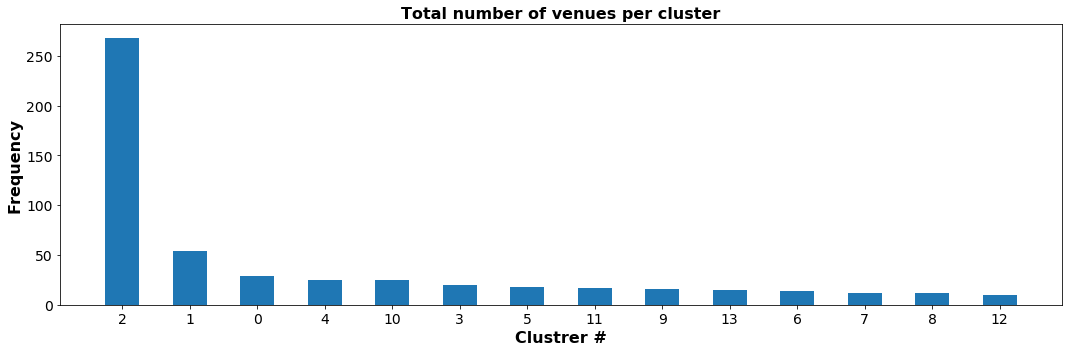

In [52]:
# Frequencies for each cluster
tmp = df_filtered['DBSCAN_label'].value_counts().to_frame().reset_index()

tmp.columns = ['label', 'Num_of_venues']
tmp = tmp.sort_values('label')
tmp.set_index('label')
tmp = tmp.sort_values(by='Num_of_venues', ascending=False)
tmp = tmp.drop(tmp[tmp['label'] == -1].index)

# initialize the plot with the specified dimensions
fig = plt.figure(figsize=(15, 5))

# Total number of venues per cluster
labels = tmp['label']
x = np.arange(len(labels))  # the label locations
y = tmp['Num_of_venues']
width = 0.5  # the width of the bars

ax = fig.add_subplot(1, 1, 1)
rects = ax.bar(x, y, width)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency', fontweight='bold', fontsize=16)
ax.set_xlabel('Clustrer #', fontweight='bold', fontsize=16)
ax.set_xticks(x)
ax.tick_params(labelsize=14)
ax.set_xticklabels(labels, fontsize=14)
ax.set_title('Total number of venues per cluster', fontweight='bold', fontsize=16)

fig.tight_layout()
plt.show()

### Areas of each cluster

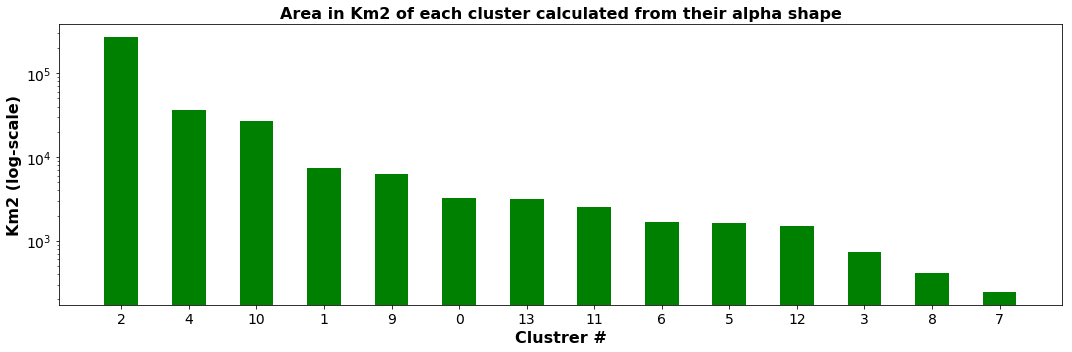

In [53]:
# Frequencies for each cluster
tmp = clusters[['DBSCAN_label', 'Area_m2']]
tmp.columns = ['label', 'Area_m2']
tmp = tmp.sort_values('label')
tmp.set_index('label')
tmp = tmp.sort_values(by='Area_m2', ascending=False)
tmp = tmp.drop(tmp[tmp['label'] == -1].index)

# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(15, 5))

# Total number of venues per cluster
labels = tmp['label']
x = np.arange(len(labels))  # the label locations
y = tmp['Area_m2']
width = 0.5  # the width of the bars

ax = fig.add_subplot(1, 1, 1)
rects = ax.bar(x, y, width, color='green')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Km2 (log-scale)',fontweight='bold', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel('Clustrer #',fontweight='bold', fontsize=16)
ax.set_xticks(x)
ax.tick_params(labelsize=14)
ax.set_xticklabels(labels, fontsize=14)
ax.set_title('Area in Km2 of each cluster calculated from their alpha shape',fontweight='bold', fontsize=16)

fig.tight_layout()
plt.show()

### Frequency Analysis of categories

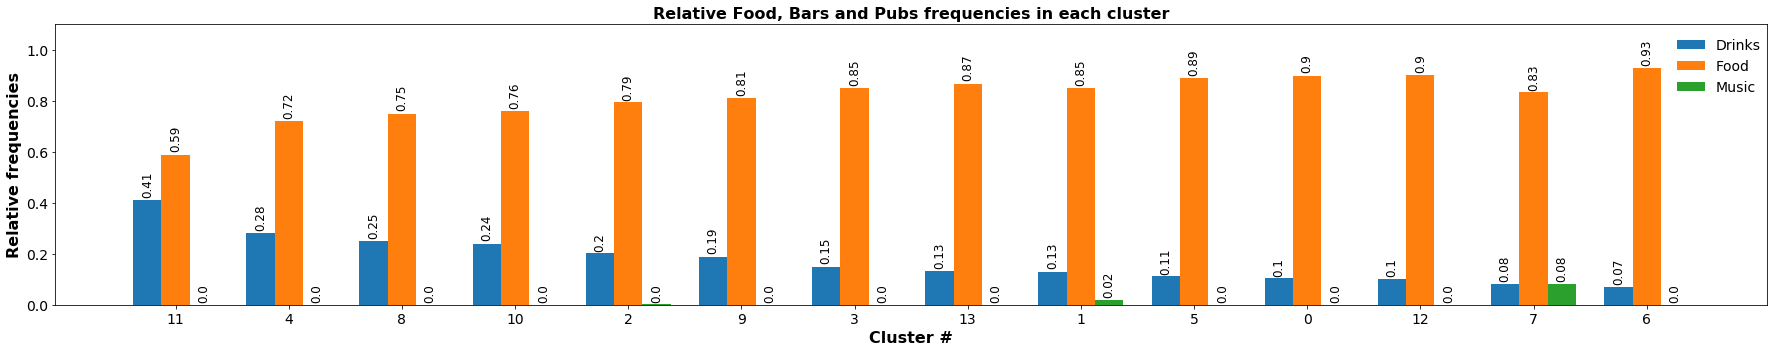

In [54]:
# Relative frequencies for Food, Bar and Music categories in each cluster
# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)

df_grouped = df_grouped.sort_values(by='Drinks', ascending=False)
labels = df_grouped['DBSCAN_label']
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

rects1 = ax.bar(x - width, df_grouped['Drinks'], width, label='Drinks')
rects2 = ax.bar(x, df_grouped['Food'], width, label='Food')
rects3 = ax.bar(x + width, df_grouped['Music'], width, label='Music')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative frequencies',fontweight='bold', fontsize=16)
ax.set_xlabel('Cluster #',fontweight='bold', fontsize=16)
ax.set_title('Relative Food, Bars and Pubs frequencies in each cluster', fontweight='bold', fontsize=16)
ax.set_xticks(x)
ax.tick_params(labelsize=14)
ax.set_xticklabels(labels, fontsize=14)
ax.legend(fontsize=14)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',rotation=90, fontsize=12)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
ax.set_ylim(0, 1.1)
lgd = ax.legend(loc='center left', frameon=False, fontsize=14, bbox_to_anchor=(0.94,0.85))
fig.tight_layout()
plt.show()

### In case the client would like to know more about the different venues in each cluster, the frequency of Foursquare venues are analyzed here:

In [56]:
# one hot encoding
df_onehot = pd.get_dummies(df_filtered[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['DBSCAN_label'] = df_filtered['DBSCAN_label'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]
print('Shape of df_onehot is: ',df_onehot.shape)
df_grouped = df_onehot.groupby('DBSCAN_label').mean().reset_index()
df_grouped = df_grouped.drop(df_grouped[df_grouped['DBSCAN_label']==-1].index)
print('Shape df_grouped is: ',df_grouped.shape)

num_top_venues = 5
c = 0
for cluster in df_grouped['DBSCAN_label']:
    print("---- Cluster "+str(cluster)+" ----")
    tmp = df_grouped[df_grouped['DBSCAN_label'] == cluster].T.reset_index()
    tmp.columns = ['Category','freq']
    tmp = tmp.iloc[1:]
    tmp['freq'] = tmp['freq'].astype(float)
    tmp = tmp.round({'freq': 2})
    display(tmp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    c += 1
    if c > 5:
        break
df_grouped.head()

Shape of df_onehot is:  (799, 79)
Shape df_grouped is:  (14, 79)
---- Cluster 0 ----


,Category,freq
0,Sushi Restaurant,0.17
1,Chinese Restaurant,0.07
2,Japanese Restaurant,0.07
3,Mediterranean Restaurant,0.07
4,Mexican Restaurant,0.07


---- Cluster 1 ----


,Category,freq
0,Italian Restaurant,0.09
1,Fast Food Restaurant,0.07
2,Diner,0.06
3,Thai Restaurant,0.06
4,Middle Eastern Restaurant,0.06


---- Cluster 2 ----


,Category,freq
0,Restaurant,0.10
1,Seafood Restaurant,0.07
2,American Restaurant,0.06
3,Beer Bar,0.06
4,Japanese Restaurant,0.06


---- Cluster 3 ----


,Category,freq
0,Fast Food Restaurant,0.30
1,Restaurant,0.15
2,Japanese Restaurant,0.10
3,Asian Restaurant,0.10
4,Juice Bar,0.10


---- Cluster 4 ----


,Category,freq
0,Bar,0.20
1,Asian Restaurant,0.08
2,Vietnamese Restaurant,0.08
3,Vegetarian / Vegan Restaurant,0.08
4,Restaurant,0.08


---- Cluster 5 ----


,Category,freq
0,Greek Restaurant,0.39
1,Italian Restaurant,0.17
2,Restaurant,0.11
3,Pizza Place,0.06
4,Sushi Restaurant,0.06


,DBSCAN_label,Afghan Restaurant,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bar,Beer Bar,Belgian Restaurant,Bistro,Brazilian Restaurant,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Health Food Store,Hotel Bar,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Music Venue,New American Restaurant,Nightclub,Persian Restaurant,Pizza Place,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sake Bar,Seafood Restaurant,Soup Place,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
1,0,0.034483,0.0,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.034483,0.068966,0.000000,0.000000,0.000000,0.00,0.0,0.068966,0.0,0.0,0.0,0.034483,0.000000,0.000000,0.0,0.034483,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.034483,0.000000,0.000000,0.068966,0.000000,0.034483,0.000000,0.00,0.068966,0.068966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.000000,0.034483,0.034483,0.068966,0.0,0.000000,0.000000,0.000000,0.000000,0.172414,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2,1,0.000000,0.0,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.055556,0.018519,0.0,0.000000,0.018519,0.000000,0.000000,0.000000,0.00,0.0,0.055556,0.0,0.0,0.0,0.018519,0.018519,0.074074,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.018519,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.018519,0.000000,0.092593,0.037037,0.037037,0.000000,0.000000,0.00,0.000000,0.018519,0.055556,0.037037,0.000000,0.000000,0.018519,0.037037,0.000000,0.000000,0.037037,0.037037,0.018519,0.018519,0.037037,0.0,0.018519,0.000000,0.000000,0.018519,0.037037,0.000000,0.0,0.055556,0.0,0.000000,0.018519,0.037037,0.0
3,2,0.000000,0.0,0.059701,0.033582,0.011194,0.041045,0.055970,0.003731,0.018657,0.007463,0.011194,0.007463,0.0,0.000000,0.003731,0.037313,0.007463,0.022388,0.00,0.0,0.007463,0.0,0.0,0.0,0.000000,0.000000,0.029851,0.0,0.000000,0.014925,0.0,0.011194,0.018657,0.003731,0.0,0.0,0.011194,0.007463,0.0,0.0,0.0,0.000000,0.003731,0.052239,0.055970,0.011194,0.000000,0.014925,0.00,0.007463,0.003731,0.003731,0.003731,0.003731,0.007463,0.000000,0.022388,0.003731,0.000000,0.029851,0.000000,0.033582,0.003731,0.100746,0.0,0.070896,0.003731,0.003731,0.029851,0.018657,0.007463,0.0,0.033582,0.0,0.029851,0.000000,0.014925,0.0
4,3,0.000000,0.0,0.050000,0.100000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.050000,0.050000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.300000,0.0,0.000000,0.050000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
5,4,0.000000,0.0,0.000000,0.080000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.040000,0.000000,0.000000,0.04,0.0,0.040000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False) 
    return row_categories_sorted.index.values[0:num_top_venues]

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['DBSCAN_label']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_sorted = pd.DataFrame(columns=columns)
df_sorted['DBSCAN_label'] = df_grouped['DBSCAN_label']

for ind in np.arange(df_grouped.shape[0]):
    df_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

df_sorted.head()

,DBSCAN_label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,Sushi Restaurant,Japanese Restaurant,Mediterranean Restaurant,Chinese Restaurant,Persian Restaurant,Restaurant,Diner,Mexican Restaurant,Beer Bar,Food & Drink Shop
2,1,Italian Restaurant,Fast Food Restaurant,Thai Restaurant,Diner,Middle Eastern Restaurant,Burger Joint,Japanese Restaurant,Juice Bar,Modern European Restaurant,Pizza Place
3,2,Restaurant,Seafood Restaurant,American Restaurant,Beer Bar,Japanese Restaurant,Italian Restaurant,Bar,Cocktail Bar,Asian Restaurant,Thai Restaurant
4,3,Fast Food Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,Juice Bar,Burger Joint,Food Court,American Restaurant,Bar,Burrito Place
5,4,Bar,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Restaurant,Diner,French Restaurant,Japanese Restaurant,Italian Restaurant,Cocktail Bar
